In [123]:
import pandas as pd
import numpy as np
import wbgapi as wb
import yfinance as yf
import scipy.stats as st
import statsmodels.api as sm
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols

from urllib.request import urlopen
from scipy.io import loadmat

from zipfile import ZipFile
from io import BytesIO

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Overall Rules

- Refrain from saving datasets locally. You may experiment with your answers on a locally saved version of the datasets, but do not upload your local files with your homework as the datasets are very large. In your submitted answers datasets should be read from the original source URL.
- Document all of your steps by writing appropriate markdown cells in your notebook. Refrain from using code comments to explain what has been done.
- Avoid duplicating code. Do not copy and paste code from one cell to another. If copying and pasting is necessary, write a suitable function for the task at hand and call that function.
- Document your use of LLMs (ChatGPT, Claude, Code Pilot etc). Either take screenshots of your steps and include them with this notebook, or give me a full log (both questions and answers) in a markdown file named HW2-LLM-LOG.md.

Failure to adhere to these guidelines will result in a 25-point deduction for each infraction.

# HW2

## Q1

There are 22 countries surrounding the Mediterranean Sea: Spain, France, Monaco, Italy, Slovenia, Croatia, Bosnia and Herzegovina, Montenegro, Albania, Greece, Turkey, Syria, Lebanon, Israel, Palestine, Egypt, Libya, Tunisia, Algeria, and Morocco, with two island countries Malta and Cyprus.

1. Get the following data for every country in the list above from the World Bank Data server (using the `wbgapi` library)

- Adult female literacy (SE.ADT.LITR.FE.ZS)
- Adult female workforce participation rate (SL.TLF.ACTI.ZS)
- Child mortality rate (SP.DYN.IMRT.IN)
- Gini index (SI.POV.GINI)
- Life expectancy (SP.DYN.LE00.IN)
- GDP (NY.GDP.PCAP.CD)

2. Write a function that does linear regression for Log(mortality) against the other variables (except mortality).
3. Analyze the regression results for Spain, France, Turkey, Syria, and Israel.
4. Analyze the results for 2 other countries of your choice.

## Answers

Let us start by getting the data:

In [3]:
countries = ['ESP','FRA','MCO','ITA','HRV','BIH','MNE','ALB','GRC','TUR','SYR','LBN',
             'ISR','PSE','EGY','LBY','TUN','DZA','MAR','MLT','CYP']

series = {'SE.ADT.LITR.FE.ZS': 'Literacy',
          'SL.TLF.ACTI.ZS': 'Participation',
          'SP.DYN.IMRT.IN': 'Mortality',
          'SP.DYN.LE00.IN': 'Expectancy',
          'SI.POV.GINI': 'GINI',
          'NY.GDP.PCAP.CD': 'GDP'}


data = wb.data.DataFrame(list(series.keys()), economy=countries).T
data

economy            ALB                                               \
series  NY.GDP.PCAP.CD SE.ADT.LITR.FE.ZS SI.POV.GINI SL.TLF.ACTI.ZS   
YR1960             NaN               NaN         NaN            NaN   
YR1961             NaN               NaN         NaN            NaN   
YR1962             NaN               NaN         NaN            NaN   
YR1963             NaN               NaN         NaN            NaN   
YR1964             NaN               NaN         NaN            NaN   
...                ...               ...         ...            ...   
YR2019     5396.214243               NaN        30.1         70.373   
YR2020     5343.037704               NaN        29.4         67.363   
YR2021     6377.203096               NaN         NaN         68.684   
YR2022     6810.114041         98.300003         NaN         71.367   
YR2023             NaN               NaN         NaN            NaN   

economy                                          BIH                    \
series  SP.DYN.IMRT.IN SP.DYN.LE00.IN NY.GDP.PCAP.CD SE.ADT.LITR.FE.ZS   
YR1960             NaN         54.439            NaN               NaN   
YR1961             NaN         55.634            NaN               NaN   
YR1962             NaN         56.671            NaN               NaN   
YR1963             NaN         57.844            NaN               NaN   
YR1964             NaN         58.983            NaN               NaN   
...                ...            ...            ...               ...   
YR2019             8.4         79.282    6094.724823               NaN   
YR2020             8.4         76.989    6095.104237               NaN   
YR2021             8.4         76.463    7230.198838               NaN   
YR2022             NaN            NaN    7568.798480         97.099998   
YR2023             NaN            NaN            NaN               NaN   

economy                             ...         TUN                 \
series  SI.POV.GINI SL.TLF.ACTI.ZS  ... SI.POV.GINI SL.TLF.ACTI.ZS   
YR1960          NaN            NaN  ...         NaN            NaN   
YR1961          NaN            NaN  ...         NaN            NaN   
YR1962          NaN            NaN  ...         NaN            NaN   
YR1963          NaN            NaN  ...         NaN            NaN   
YR1964          NaN            NaN  ...         NaN            NaN   
...             ...            ...  ...         ...            ...   
YR2019          NaN         57.265  ...         NaN         51.891   
YR2020          NaN         57.784  ...         NaN         49.715   
YR2021          NaN         60.999  ...        33.7         50.037   
YR2022          NaN         61.552  ...         NaN         52.348   
YR2023          NaN            NaN  ...         NaN            NaN   

economy                                          TUR                    \
series  SP.DYN.IMRT.IN SP.DYN.LE00.IN NY.GDP.PCAP.CD SE.ADT.LITR.FE.ZS   
YR1960             NaN         43.940     275.041699               NaN   
YR1961             NaN         44.146     282.742464               NaN   
YR1962           181.7         45.513     307.306286               NaN   
YR1963           173.2         46.500     347.177091               NaN   
YR1964           165.0         47.365     365.133869               NaN   
...                ...            ...            ...               ...   
YR2019            14.5         75.993    9215.440875         94.424042   
YR2020            14.3         75.292    8638.739133               NaN   
YR2021            14.0         73.772    9743.213131               NaN   
YR2022             NaN            NaN   10674.504173               NaN   
YR2023             NaN            NaN            NaN               NaN   

economy                                                           
series  SI.POV.GINI SL.TLF.ACTI.ZS SP.DYN.IMRT.IN SP.DYN.LE00.IN  
YR1960          NaN            NaN          171.5         50.740  
YR1961          NaN            NaN    

For the models, I am going to rename the columns, interpolate the missing values and then backfill the rest.

In [12]:
data.rename(columns=series,inplace=True)
data.interpolate(inplace=True)
data.bfill(inplace=True)
data

economy          ALB                                                      \
series           GDP   Literacy  GINI Participation Mortality Expectancy   
YR1960    639.484730  98.252274  27.0        69.274      76.7     54.439   
YR1961    639.484730  98.252274  27.0        69.274      76.7     55.634   
YR1962    639.484730  98.252274  27.0        69.274      76.7     56.671   
YR1963    639.484730  98.252274  27.0        69.274      76.7     57.844   
YR1964    639.484730  98.252274  27.0        69.274      76.7     58.983   
...              ...        ...   ...           ...       ...        ...   
YR2019   5396.214243  97.650823  30.1        70.373       8.4     79.282   
YR2020   5343.037704  97.867216  29.4        67.363       8.4     76.989   
YR2021   6377.203096  98.083610  29.4        68.684       8.4     76.463   
YR2022   6810.114041  98.300003  29.4        71.367       8.4     76.463   
YR2023   6810.114041  98.300003  29.4        71.367       8.4     76.463   

economy          BIH                                 ...    TUN                \
series           GDP   Literacy  GINI Participation  ...   GINI Participation   
YR1960    333.783179  81.959328  30.0        49.564  ...  43.40        50.628   
YR1961    333.783179  81.959328  30.0        49.564  ...  43.40        50.628   
YR1962    333.783179  81.959328  30.0        49.564  ...  43.40        50.628   
YR1963    333.783179  81.959328  30.0        49.564  ...  43.40        50.628   
YR1964    333.783179  81.959328  30.0        49.564  ...  43.40        50.628   
...              ...        ...   ...           ...  ...    ...           ...   
YR2019   6094.724823  96.370163  33.0        57.265  ...  33.40        51.891   
YR2020   6095.104237  96.613441  33.0        57.784  ...  33.55        49.715   
YR2021   7230.198838  96.856720  33.0        60.999  ...  33.70        50.037   
YR2022   7568.798480  97.099998  33.0        61.552  ...  33.70        52.348   
YR2023   7568.798480  97.099998  33.0        61.552  ...  33.70        52.348   

economy                                TUR                                 \
series  Mortality Expectancy           GDP   Literacy  GINI Participation   
YR1960      181.7     43.940    275.041699  45.098919  43.5        60.068   
YR1961      181.7     44.146    282.742464  45.098919  43.5        60.068   
YR1962      181.7     45.513    307.306286  45.098919  43.5        60.068   
YR1963      173.2     46.500    347.177091  45.098919  43.5        60.068   
YR1964      165.0     47.365    365.133869  45.098919  43.5        60.068   
...           ...        ...           ...        ...   ...           ...   
YR2019       14.5     75.993   9215.440875  94.424042  43.8        57.710   
YR2020       14.3     75.292   8638.739133  94.424042  43.0        54.048   
YR2021       14.0     73.772   9743.213131  94.424042  44.4        56.321   
YR2022       14.0     73.772  10674.504173  94.424042  44.4        58.314   
YR2023       14.0     73.772  10674.504173  94.424042  44.4        58.314   

economy                       
series  Mortality Expectancy  
YR1960      171.5     50.740  
YR1961      166.2     51.550  
YR1962      160.8     52.382  
YR1963      155.5     53.173  
YR1964      150.4     53.714  
...           ...        ...  
YR2019        8.6     77.832  
YR2020        8.1     75.850  
YR2021        7.7     76.032  
YR2022        7.7     76.032  
YR2023        7.7     76.032  

[64 rows x 126 columns]

In [13]:
def experiment1(data,country, formula):
    tmp = data[country]
    tmp['Mortality'] = np.log(tmp['Mortality'])
    res = ols(formula, data=tmp).fit()
    return res

### Turkey

Let us fit a model using the same order given in the original data frame.

In [14]:
res = experiment1(data,'TUR','Mortality ~ GDP + Literacy + GINI + Participation + Expectancy')
res.summary()
sm.stats.anova_lm(res)

/tmp/ipykernel_311690/1482972064.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Mortality'] = np.log(tmp['Mortality'])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mortality   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     605.2
Date:                Fri, 29 Mar 2024   Prob (F-statistic):           1.10e-48
Time:                        20:46:50   Log-Likelihood:                 37.721
No. Observations:                  64   AIC:                            -63.44
Df Residuals:                      58   BIC:                            -50.49
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        14.0203      3.204      4.376      0.000       7.607      20.433
GDP           -7.343e-05   1.08e-05     -6.805      0.000    -9.5e-05   -5.18e-05
Literacy         -0.0271      0.005     -5.690      0.000      -0.037      -0.018
GINI             -0.1296      0.073     -1.766      0.083      -0.277       0.017
Participation    -0.0106      0.007     -1.533      0.131      -0.024       0.003
Expectancy       -0.0276      0.009     -3.015      0.004      -0.046      -0.009
==============================================================================
Omnibus:                        9.959   Durbin-Watson:                   0.330
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               11.233
Skew:                          -0.683   Prob(JB):                      0.00364
Kurtosis:                       4.532   Cond. No.                     1.08e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,df,sum_sq,mean_sq,F,PR(>F)
GDP,1.0,54.158242,54.158242,2724.721492,1.873110e-50
Literacy,1.0,5.732678,5.732678,288.413179,3.530806e-24
GINI,1.0,0.060456,0.060456,3.041582,8.645478e-02
Participation,1.0,0.013322,0.013322,0.670253,4.163145e-01
Expectancy,1.0,0.180722,0.180722,9.092188,3.804982e-03
Residual,58.0,1.152844,0.019877,NaN,NaN


When you change the order of the variables, their effect on the variation changes. Compare the previous model with this one.

In [16]:
res = experiment1(data,'TUR','Mortality ~ Literacy + Participation + Expectancy + GDP + GINI')
res.summary()
sm.stats.anova_lm(res)

/tmp/ipykernel_311690/1482972064.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Mortality'] = np.log(tmp['Mortality'])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mortality   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     605.2
Date:                Fri, 29 Mar 2024   Prob (F-statistic):           1.10e-48
Time:                        20:47:02   Log-Likelihood:                 37.721
No. Observations:                  64   AIC:                            -63.44
Df Residuals:                      58   BIC:                            -50.49
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        14.0203      3.204      4.376      0.000       7.607      20.433
Literacy         -0.0271      0.005     -5.690      0.000      -0.037      -0.018
Participation    -0.0106      0.007     -1.533      0.131      -0.024       0.003
Expectancy       -0.0276      0.009     -3.015      0.004      -0.046      -0.009
GDP           -7.343e-05   1.08e-05     -6.805      0.000    -9.5e-05   -5.18e-05
GINI             -0.1296      0.073     -1.766      0.083      -0.277       0.017
==============================================================================
Omnibus:                        9.959   Durbin-Watson:                   0.330
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               11.233
Skew:                          -0.683   Prob(JB):                      0.00364
Kurtosis:                       4.532   Cond. No.                     1.08e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,df,sum_sq,mean_sq,F,PR(>F)
Literacy,1.0,59.067875,59.067875,2971.726998,1.588988e-51
Participation,1.0,0.000011,0.000011,0.000535,9.816314e-01
Expectancy,1.0,0.038496,0.038496,1.936754,1.693359e-01
GDP,1.0,0.977064,0.977064,49.156449,2.807273e-09
GINI,1.0,0.061974,0.061974,3.117960,8.269686e-02
Residual,58.0,1.152844,0.019877,NaN,NaN


After a few tries you'll find that for Turkey the following model has the best $R^2$ score. This indicates that the factor that effects the child mortality in Turkey is mothers' literacy and GDP. The literacy has statistically verifiable negative effect, so does the GDP as you can see below.

In [17]:
res = experiment1(data,'TUR','Mortality ~ Literacy + GDP')
res.summary()
sm.stats.anova_lm(res)

/tmp/ipykernel_311690/1482972064.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Mortality'] = np.log(tmp['Mortality'])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mortality   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1298.
Date:                Fri, 29 Mar 2024   Prob (F-statistic):           1.02e-50
Time:                        20:47:08   Log-Likelihood:                 31.338
No. Observations:                  64   AIC:                            -56.68
Df Residuals:                      61   BIC:                            -50.20
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.7094      0.127     52.677      0.000       6.455       6.964
Literacy      -0.0391      0.002    -15.763      0.000      -0.044      -0.034
GDP        -6.642e-05   1.11e-05     -5.973      0.000   -8.87e-05   -4.42e-05
==============================================================================
Omnibus:                        2.461   Durbin-Watson:                   0.136
Prob(Omnibus):                  0.292   Jarque-Bera (JB):                2.168
Skew:                          -0.343   Prob(JB):                        0.338
Kurtosis:                       2.415   Cond. No.                     3.99e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,df,sum_sq,mean_sq,F,PR(>F)
Literacy,1.0,59.067875,59.067875,2560.240750,1.586878e-51
GDP,1.0,0.823044,0.823044,35.674075,1.298610e-07
Residual,61.0,1.407344,0.023071,NaN,NaN


### Spain

Let us check what happens with Spain:

In [18]:
res = experiment1(data,'ESP','Mortality ~ GDP + Literacy + GINI + Participation + Expectancy')
res.summary()
sm.stats.anova_lm(res)

/tmp/ipykernel_311690/1482972064.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Mortality'] = np.log(tmp['Mortality'])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mortality   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     1597.
Date:                Fri, 29 Mar 2024   Prob (F-statistic):           9.39e-61
Time:                        20:47:13   Log-Likelihood:                 71.335
No. Observations:                  64   AIC:                            -130.7
Df Residuals:                      58   BIC:                            -117.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        19.1006      1.168     16.356      0.000      16.763      21.438
GDP           -9.168e-06   4.74e-06     -1.933      0.058   -1.87e-05    3.24e-07
Literacy         -0.0421      0.012     -3.447      0.001      -0.067      -0.018
GINI              0.0175      0.012      1.512      0.136      -0.006       0.041
Participation     0.0398      0.005      7.716      0.000       0.029       0.050
Expectancy       -0.2084      0.008    -26.033      0.000      -0.224      -0.192
==============================================================================
Omnibus:                        1.603   Durbin-Watson:                   0.981
Prob(Omnibus):                  0.449   Jarque-Bera (JB):                1.584
Skew:                           0.357   Prob(JB):                        0.453
Kurtosis:                       2.711   Cond. No.                     2.05e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.05e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,df,sum_sq,mean_sq,F,PR(>F)
GDP,1.0,47.465493,47.465493,6827.219391,7.243122e-62
Literacy,1.0,2.977515,2.977515,428.272069,1.840223e-28
GINI,1.0,0.002050,0.002050,0.294799,5.892424e-01
Participation,1.0,0.369093,0.369093,53.088614,9.684905e-10
Expectancy,1.0,4.711790,4.711790,677.722331,1.097174e-33
Residual,58.0,0.403239,0.006952,NaN,NaN


In [19]:
res = experiment1(data,'TUR','Mortality ~ Literacy + GDP')
res.summary()
sm.stats.anova_lm(res)

/tmp/ipykernel_311690/1482972064.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Mortality'] = np.log(tmp['Mortality'])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mortality   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1298.
Date:                Fri, 29 Mar 2024   Prob (F-statistic):           1.02e-50
Time:                        20:47:17   Log-Likelihood:                 31.338
No. Observations:                  64   AIC:                            -56.68
Df Residuals:                      61   BIC:                            -50.20
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.7094      0.127     52.677      0.000       6.455       6.964
Literacy      -0.0391      0.002    -15.763      0.000      -0.044      -0.034
GDP        -6.642e-05   1.11e-05     -5.973      0.000   -8.87e-05   -4.42e-05
==============================================================================
Omnibus:                        2.461   Durbin-Watson:                   0.136
Prob(Omnibus):                  0.292   Jarque-Bera (JB):                2.168
Skew:                          -0.343   Prob(JB):                        0.338
Kurtosis:                       2.415   Cond. No.                     3.99e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,df,sum_sq,mean_sq,F,PR(>F)
Literacy,1.0,59.067875,59.067875,2560.240750,1.586878e-51
GDP,1.0,0.823044,0.823044,35.674075,1.298610e-07
Residual,61.0,1.407344,0.023071,NaN,NaN


The same model works pretty well for Spain too. Let us try the others:

### France

In [20]:
res = experiment1(data,'FRA','Mortality ~ GDP + Literacy + GINI + Participation + Expectancy')
res.summary()
sm.stats.anova_lm(res)

/tmp/ipykernel_311690/1482972064.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Mortality'] = np.log(tmp['Mortality'])


ValueError: zero-size array to reduction operation maximum which has no identity

We don't have enough data for France. 

### Israel

Let us move to Israel:


In [22]:
res = experiment1(data,'ISR','Mortality ~ GDP + Literacy + GINI + Participation + Expectancy')
res.summary()
sm.stats.anova_lm(res)

/tmp/ipykernel_311690/1482972064.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Mortality'] = np.log(tmp['Mortality'])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mortality   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     825.8
Date:                Fri, 29 Mar 2024   Prob (F-statistic):           4.80e-51
Time:                        20:47:46   Log-Likelihood:                 50.750
No. Observations:                  64   AIC:                            -91.50
Df Residuals:                      59   BIC:                            -80.71
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0018      0.000     12.102      0.000       0.002       0.002
GDP           -1.015e-05   4.06e-06     -2.498      0.015   -1.83e-05   -2.02e-06
Literacy          0.1618      0.013     12.102      0.000       0.135       0.188
GINI             -0.0116      0.014     -0.838      0.406      -0.039       0.016
Participation     0.0403      0.016      2.463      0.017       0.008       0.073
Expectancy       -0.1862      0.015    -12.109      0.000      -0.217      -0.155
==============================================================================
Omnibus:                       12.901   Durbin-Watson:                   0.452
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               14.595
Skew:                           0.900   Prob(JB):                     0.000677
Kurtosis:                       4.494   Cond. No.                     2.75e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.7e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

,df,sum_sq,mean_sq,F,PR(>F)
GDP,1.0,38.640120,38.640120,2971.331109,3.589046e-52
Literacy,1.0,0.193660,0.193660,14.891992,2.846171e-04
GINI,1.0,2.344475,2.344475,180.284409,1.367763e-19
Participation,1.0,0.036959,0.036959,2.842042,9.710960e-02
Expectancy,1.0,1.870223,1.870223,143.815612,1.849653e-17
Residual,59.0,0.767254,0.013004,NaN,NaN


Israel is an anomaly: While for the other countries we looked (Turkey, Spain) female literacy was the most important factor reducing child mortality, for Israel, it was GDP and life expectancy.

In [23]:
res = experiment1(data,'ISR','Mortality ~ GDP + Expectancy')
res.summary()
sm.stats.anova_lm(res)

/tmp/ipykernel_311690/1482972064.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Mortality'] = np.log(tmp['Mortality'])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mortality   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1546.
Date:                Fri, 29 Mar 2024   Prob (F-statistic):           5.56e-53
Time:                        20:47:52   Log-Likelihood:                 47.618
No. Observations:                  64   AIC:                            -89.24
Df Residuals:                      61   BIC:                            -82.76
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.4501      0.760     21.642      0.000      14.930      17.970
GDP        -4.943e-06   2.93e-06     -1.688      0.097   -1.08e-05    9.14e-07
Expectancy    -0.1845      0.011    -17.478      0.000      -0.206      -0.163
==============================================================================
Omnibus:                       17.574   Durbin-Watson:                   0.367
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.971
Skew:                           1.071   Prob(JB):                     6.23e-06
Kurtosis:                       5.097   Cond. No.                     1.22e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,df,sum_sq,mean_sq,F,PR(>F)
GDP,1.0,38.640120,38.640120,2785.604871,1.281236e-52
Expectancy,1.0,4.237413,4.237413,305.479361,1.971118e-25
Residual,61.0,0.846153,0.013871,NaN,NaN


### Italy

Let us check Italy:

In [24]:
res = experiment1(data,'ITA','Mortality ~ GDP + Literacy + GINI + Participation + Expectancy')
res.summary()
sm.stats.anova_lm(res)

/tmp/ipykernel_311690/1482972064.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Mortality'] = np.log(tmp['Mortality'])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mortality   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1339.
Date:                Fri, 29 Mar 2024   Prob (F-statistic):           1.51e-58
Time:                        20:47:59   Log-Likelihood:                 65.388
No. Observations:                  64   AIC:                            -118.8
Df Residuals:                      58   BIC:                            -105.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        23.6509      4.020      5.884      0.000      15.605      31.697
GDP            6.242e-06   3.99e-06      1.566      0.123   -1.74e-06    1.42e-05
Literacy         -0.0862      0.053     -1.619      0.111      -0.193       0.020
GINI              0.0350      0.012      2.837      0.006       0.010       0.060
Participation     0.0245      0.009      2.704      0.009       0.006       0.043
Expectancy       -0.2071      0.012    -16.954      0.000      -0.232      -0.183
==============================================================================
Omnibus:                        2.387   Durbin-Watson:                   0.878
Prob(Omnibus):                  0.303   Jarque-Bera (JB):                1.900
Skew:                          -0.421   Prob(JB):                        0.387
Kurtosis:                       3.072   Cond. No.                     7.90e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.9e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,df,sum_sq,mean_sq,F,PR(>F)
GDP,1.0,51.800974,51.800974,6187.034067,1.228046e-60
Literacy,1.0,0.690940,0.690940,82.524843,9.628506e-13
GINI,1.0,0.564973,0.564973,67.479603,2.678090e-11
Participation,1.0,0.575313,0.575313,68.714513,2.008053e-11
Expectancy,1.0,2.406485,2.406485,287.427142,3.836137e-24
Residual,58.0,0.485605,0.008373,NaN,NaN


It seems Italy is a little different.

In [25]:
res = experiment1(data,'ITA','Mortality ~ Literacy + Expectancy')
res.summary()
sm.stats.anova_lm(res)

/tmp/ipykernel_311690/1482972064.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Mortality'] = np.log(tmp['Mortality'])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mortality   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2968.
Date:                Fri, 29 Mar 2024   Prob (F-statistic):           1.69e-61
Time:                        20:48:05   Log-Likelihood:                 59.978
No. Observations:                  64   AIC:                            -114.0
Df Residuals:                      61   BIC:                            -107.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.8951      2.351      5.911      0.000       9.194      18.596
Literacy       0.0543      0.032      1.721      0.090      -0.009       0.117
Expectancy    -0.2210      0.010    -22.754      0.000      -0.240      -0.202
==============================================================================
Omnibus:                        0.480   Durbin-Watson:                   0.758
Prob(Omnibus):                  0.787   Jarque-Bera (JB):                0.150
Skew:                          -0.103   Prob(JB):                        0.928
Kurtosis:                       3.117   Cond. No.                     2.40e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.4e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,df,sum_sq,mean_sq,F,PR(>F)
Literacy,1.0,51.068300,51.068300,5417.263510,2.715190e-61
Expectancy,1.0,4.880946,4.880946,517.764844,1.687004e-31
Residual,61.0,0.575044,0.009427,NaN,NaN


### Greece

In [26]:
res = experiment1(data,'GRC','Mortality ~ Expectancy + Literacy')
res.summary()
sm.stats.anova_lm(res)

/tmp/ipykernel_311690/1482972064.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Mortality'] = np.log(tmp['Mortality'])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mortality   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     2265.
Date:                Fri, 29 Mar 2024   Prob (F-statistic):           5.80e-58
Time:                        20:48:26   Log-Likelihood:                 57.487
No. Observations:                  64   AIC:                            -109.0
Df Residuals:                      61   BIC:                            -102.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.5501      0.349     64.560      0.000      21.852      23.249
Expectancy    -0.1784      0.008    -23.721      0.000      -0.193      -0.163
Literacy      -0.0744      0.008     -9.177      0.000      -0.091      -0.058
==============================================================================
Omnibus:                        4.575   Durbin-Watson:                   0.445
Prob(Omnibus):                  0.102   Jarque-Bera (JB):                4.310
Skew:                          -0.634   Prob(JB):                        0.116
Kurtosis:                       2.918   Cond. No.                     3.26e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,df,sum_sq,mean_sq,F,PR(>F)
Expectancy,1.0,45.307060,45.307060,4446.111527,1.044772e-58
Literacy,1.0,0.858219,0.858219,84.219506,4.282908e-13
Residual,61.0,0.621606,0.010190,NaN,NaN


### Egypt

In [27]:
res = experiment1(data,'EGY','Mortality ~ Literacy + Expectancy')
res.summary()
sm.stats.anova_lm(res)

/tmp/ipykernel_311690/1482972064.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Mortality'] = np.log(tmp['Mortality'])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mortality   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     8899.
Date:                Fri, 29 Mar 2024   Prob (F-statistic):           5.90e-76
Time:                        20:48:31   Log-Likelihood:                 101.27
No. Observations:                  64   AIC:                            -196.5
Df Residuals:                      61   BIC:                            -190.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.7807      0.084     93.000      0.000       7.613       7.948
Literacy      -0.0309      0.001    -32.854      0.000      -0.033      -0.029
Expectancy    -0.0393      0.002    -20.522      0.000      -0.043      -0.035
==============================================================================
Omnibus:                        0.266   Durbin-Watson:                   0.171
Prob(Omnibus):                  0.875   Jarque-Bera (JB):                0.138
Skew:                          -0.113   Prob(JB):                        0.933
Kurtosis:                       2.968   Cond. No.                     1.00e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,df,sum_sq,mean_sq,F,PR(>F)
Literacy,1.0,45.072382,45.072382,17377.230450,1.244424e-76
Expectancy,1.0,1.092332,1.092332,421.138441,4.484325e-29
Residual,61.0,0.158219,0.002594,NaN,NaN


Let us summarize

| Country | Variable 1 | Variable 2 | $R^2$ |
|---------|------------|------------|-------|
| Turkey  | Literacy   |    GDP     | %97.7 |
| Spain   | Literacy   |    GDP     | %97.7 |
| France  |            |            |       |
| Israel  |   GDP      | Expectancy | %98.1 |
| Italy   | Literacy   | Expectancy | %99.0 |
| Greece  | Expectancy | Literacy   | %98.7 |
| Egypt   | Literacy   | Expectancy | %99.7 |


The order of the variables is also important. Try the models with the order of the important variables reversed, and see that the ANOVA results show that the weight of the most important variable drops.  On the other hand, if you add interaction terms the ANOVA results show no additional drop in the variance (look at the residuals.)

## Q2

Get the following commodity price data from yahoo finance using the `yfinance` library:

- Silver (SI=F)
- Copper (HG=F)
- Platinum (PL=F)
- Gold (GC=F)
- Palladium (PA=F)

1. Write a linear regression model that relates the gold futures in terms of the other precious metals.
2. Analyze the regression results.
3. Does the model improve if we add interaction terms? Explain.
4. Now, do the same for each futures in the list above.

In [3]:
commodities = {'SI=F': 'Silver', 'HG=F': 'Copper', 'PL=F': 'Platinum', 'GC=F': 'Gold', 'PA=F': 'Palladium'} 
finance = yf.download(list(commodities))
finance

[*********************100%%**********************]  5 of 5 completed


Adj Close                                              \
                   GC=F    HG=F         PA=F        PL=F       SI=F   
Date                                                                  
2000-01-04          NaN     NaN   441.899994  429.700012        NaN   
2000-01-05          NaN     NaN   438.100006  419.899994        NaN   
2000-01-06          NaN     NaN   435.299988  412.000000        NaN   
2000-01-07          NaN     NaN   443.899994  414.000000        NaN   
2000-01-10          NaN     NaN   451.950012  415.000000        NaN   
...                 ...     ...          ...         ...        ...   
2024-03-25  2174.800049  4.0070  1007.799988  906.700012  24.745001   
2024-03-26  2175.600098  3.9960   992.700012  908.599976  24.483000   
2024-03-27  2190.600098  3.9925   979.000000  895.900024  24.625000   
2024-03-28  2217.399902  4.0035  1009.500000  907.700012  24.797001   
2024-04-01  2270.199951  4.0620  1000.500000  914.299988  25.315001   

                  Close                                              ...  \
                   GC=F    HG=F         PA=F        PL=F       SI=F  ...   
Date                                                                 ...   
2000-01-04          NaN     NaN   441.899994  429.700012        NaN  ...   
2000-01-05          NaN     NaN   438.100006  419.899994        NaN  ...   
2000-01-06          NaN     NaN   435.299988  412.000000        NaN  ...   
2000-01-07          NaN     NaN   443.899994  414.000000        NaN  ...   
2000-01-10          NaN     NaN   451.950012  415.000000        NaN  ...   
...                 ...     ...          ...         ...        ...  ...   
2024-03-25  2174.800049  4.0070  1007.799988  906.700012  24.745001  ...   
2024-03-26  2175.600098  3.9960   992.700012  908.599976  24.483000  ...   
2024-03-27  2190.600098  3.9925   979.000000  895.900024  24.625000  ...   
2024-03-28  2217.399902  4.0035  1009.500000  907.700012  24.797001  ...   
2024-04-01  2270.199951  4.0620  1000.500000  914.299988  25.315001  ...   

                   Open                                                Volume  \
                   GC=F    HG=F         PA=F        PL=F       SI=F      GC=F   
Date                                                                            
2000-01-04          NaN     NaN   445.000000  428.000000        NaN       NaN   
2000-01-05          NaN     NaN   436.000000  428.000000        NaN       NaN   
2000-01-06          NaN     NaN   434.500000  415.000000        NaN       NaN   
2000-01-07          NaN     NaN   437.000000  408.000000        NaN       NaN   
2000-01-10          NaN     NaN   443.899994  414.000000        NaN       NaN   
...                 ...     ...          ...         ...        ...       ...   
2024-03-25  2166.199951  3.9995  1007.799988  906.700012  24.815001      79.0   
2024-03-26  2182.699951  3.9800   992.700012  908.599976  24.639999  202373.0   
2024-03-27  2179.399902  3.9955   979.000000  903.799988  24.424999   31200.0   
2024-03-28  2193.600098  4.0195  1009.500000  897.900024  24.684999   31200.0   
2024-04-01  2259.199951  4.0310  1023.000000  922.700012  25.139999  119135.0   

                                               
               HG=F    PA=F     PL=F     SI=F  
Date                                           
2000-01-04      NaN   177.0    632.0      NaN  
2000-01-05      NaN   319.0    571.0      NaN  
2000-01-06      NaN   180.0    494.0      NaN  
2000-01-07      NaN   102.0    130.0      NaN  
2000-01-10      NaN   143.0     24.0      NaN  
...             ...     ...      ...      ...  
2024-03-25    676.0     0.0      0.0     69.0  
2024-03-26    852.0    10.0  12088.0    663.0  
2024-03-27    715.0     0.0   3032.0    215.0  
2024-03-28    715.0     0.0   3032.0    215.0  
2024-04-01  50030.0  1619.0  13008.0  43399.0  

[6091 rows x 30 columns]

In [4]:
finance.rename(columns=commodities, inplace=True)
finance

Adj Close                                              \
                   Gold  Copper    Palladium    Platinum     Silver   
Date                                                                  
2000-01-04          NaN     NaN   441.899994  429.700012        NaN   
2000-01-05          NaN     NaN   438.100006  419.899994        NaN   
2000-01-06          NaN     NaN   435.299988  412.000000        NaN   
2000-01-07          NaN     NaN   443.899994  414.000000        NaN   
2000-01-10          NaN     NaN   451.950012  415.000000        NaN   
...                 ...     ...          ...         ...        ...   
2024-03-25  2174.800049  4.0070  1007.799988  906.700012  24.745001   
2024-03-26  2175.600098  3.9960   992.700012  908.599976  24.483000   
2024-03-27  2190.600098  3.9925   979.000000  895.900024  24.625000   
2024-03-28  2217.399902  4.0035  1009.500000  907.700012  24.797001   
2024-04-01  2270.199951  4.0620  1000.500000  914.299988  25.315001   

                  Close                                              ...  \
                   Gold  Copper    Palladium    Platinum     Silver  ...   
Date                                                                 ...   
2000-01-04          NaN     NaN   441.899994  429.700012        NaN  ...   
2000-01-05          NaN     NaN   438.100006  419.899994        NaN  ...   
2000-01-06          NaN     NaN   435.299988  412.000000        NaN  ...   
2000-01-07          NaN     NaN   443.899994  414.000000        NaN  ...   
2000-01-10          NaN     NaN   451.950012  415.000000        NaN  ...   
...                 ...     ...          ...         ...        ...  ...   
2024-03-25  2174.800049  4.0070  1007.799988  906.700012  24.745001  ...   
2024-03-26  2175.600098  3.9960   992.700012  908.599976  24.483000  ...   
2024-03-27  2190.600098  3.9925   979.000000  895.900024  24.625000  ...   
2024-03-28  2217.399902  4.0035  1009.500000  907.700012  24.797001  ...   
2024-04-01  2270.199951  4.0620  1000.500000  914.299988  25.315001  ...   

                   Open                                                Volume  \
                   Gold  Copper    Palladium    Platinum     Silver      Gold   
Date                                                                            
2000-01-04          NaN     NaN   445.000000  428.000000        NaN       NaN   
2000-01-05          NaN     NaN   436.000000  428.000000        NaN       NaN   
2000-01-06          NaN     NaN   434.500000  415.000000        NaN       NaN   
2000-01-07          NaN     NaN   437.000000  408.000000        NaN       NaN   
2000-01-10          NaN     NaN   443.899994  414.000000        NaN       NaN   
...                 ...     ...          ...         ...        ...       ...   
2024-03-25  2166.199951  3.9995  1007.799988  906.700012  24.815001      79.0   
2024-03-26  2182.699951  3.9800   992.700012  908.599976  24.639999  202373.0   
2024-03-27  2179.399902  3.9955   979.000000  903.799988  24.424999   31200.0   
2024-03-28  2193.600098  4.0195  1009.500000  897.900024  24.684999   31200.0   
2024-04-01  2259.199951  4.0310  1023.000000  922.700012  25.139999  119135.0   

                                                 
             Copper Palladium Platinum   Silver  
Date                                             
2000-01-04      NaN     177.0    632.0      NaN  
2000-01-05      NaN     319.0    571.0      NaN  
2000-01-06      NaN     180.0    494.0      NaN  
2000-01-07      NaN     102.0    130.0      NaN  
2000-01-10      NaN     143.0     24.0      NaN  
...             ...       ...      ...      ...  
2024-03-25    676.0       0.0      0.0     69.0  
2024-03-26    852.0      10.0  12088.0    663.0  
2024-03-27    715.0       0.0   3032.0    215.0  
2024-03-28    715.0       0.0   3032.0    215.0  
2024-04-01  50030.0    1619.0  13008.0  43399.0  

[6091 rows x 30 columns]

In [5]:
finance.interpolate(inplace=True)
finance.bfill(inplace=True)
finance

Adj Close                                              \
                   Gold  Copper    Palladium    Platinum     Silver   
Date                                                                  
2000-01-04   273.899994  0.8850   441.899994  429.700012   4.930000   
2000-01-05   273.899994  0.8850   438.100006  419.899994   4.930000   
2000-01-06   273.899994  0.8850   435.299988  412.000000   4.930000   
2000-01-07   273.899994  0.8850   443.899994  414.000000   4.930000   
2000-01-10   273.899994  0.8850   451.950012  415.000000   4.930000   
...                 ...     ...          ...         ...        ...   
2024-03-25  2174.800049  4.0070  1007.799988  906.700012  24.745001   
2024-03-26  2175.600098  3.9960   992.700012  908.599976  24.483000   
2024-03-27  2190.600098  3.9925   979.000000  895.900024  24.625000   
2024-03-28  2217.399902  4.0035  1009.500000  907.700012  24.797001   
2024-04-01  2270.199951  4.0620  1000.500000  914.299988  25.315001   

                  Close                                              ...  \
                   Gold  Copper    Palladium    Platinum     Silver  ...   
Date                                                                 ...   
2000-01-04   273.899994  0.8850   441.899994  429.700012   4.930000  ...   
2000-01-05   273.899994  0.8850   438.100006  419.899994   4.930000  ...   
2000-01-06   273.899994  0.8850   435.299988  412.000000   4.930000  ...   
2000-01-07   273.899994  0.8850   443.899994  414.000000   4.930000  ...   
2000-01-10   273.899994  0.8850   451.950012  415.000000   4.930000  ...   
...                 ...     ...          ...         ...        ...  ...   
2024-03-25  2174.800049  4.0070  1007.799988  906.700012  24.745001  ...   
2024-03-26  2175.600098  3.9960   992.700012  908.599976  24.483000  ...   
2024-03-27  2190.600098  3.9925   979.000000  895.900024  24.625000  ...   
2024-03-28  2217.399902  4.0035  1009.500000  907.700012  24.797001  ...   
2024-04-01  2270.199951  4.0620  1000.500000  914.299988  25.315001  ...   

                   Open                                                Volume  \
                   Gold  Copper    Palladium    Platinum     Silver      Gold   
Date                                                                            
2000-01-04   273.899994  0.8790   445.000000  428.000000   4.950000       0.0   
2000-01-05   273.899994  0.8790   436.000000  428.000000   4.950000       0.0   
2000-01-06   273.899994  0.8790   434.500000  415.000000   4.950000       0.0   
2000-01-07   273.899994  0.8790   437.000000  408.000000   4.950000       0.0   
2000-01-10   273.899994  0.8790   443.899994  414.000000   4.950000       0.0   
...                 ...     ...          ...         ...        ...       ...   
2024-03-25  2166.199951  3.9995  1007.799988  906.700012  24.815001      79.0   
2024-03-26  2182.699951  3.9800   992.700012  908.599976  24.639999  202373.0   
2024-03-27  2179.399902  3.9955   979.000000  903.799988  24.424999   31200.0   
2024-03-28  2193.600098  4.0195  1009.500000  897.900024  24.684999   31200.0   
2024-04-01  2259.199951  4.0310  1023.000000  922.700012  25.139999  119135.0   

                                                 
             Copper Palladium Platinum   Silver  
Date                                             
2000-01-04   2886.0     177.0    632.0   2319.0  
2000-01-05   2886.0     319.0    571.0   2319.0  
2000-01-06   2886.0     180.0    494.0   2319.0  
2000-01-07   2886.0     102.0    130.0   2319.0  
2000-01-10   2886.0     143.0     24.0   2319.0  
...             ...       ...      ...      ...  
2024-03-25    676.0       0.0      0.0     69.0  
2024-03-26    852.0      10.0  12088.0    663.0  
2024-03-27    715.0       0.0   3032.0    215.0  
2024-03-28    715.0       0.0   3032.0    215.0  
2024-04-01  50030.0    1619.0  13008.0  43399.0  

[6091 rows x 30 columns]

In [6]:
def experiment2(data,select,formula):
    tmp = data[select]
    res = ols(formula, data=tmp).fit()
    return res 

We need to find a good fitting model. We start with the largest possible model where we put every possible interaction into the model. By looking at the ANOVA we can determine which variables and interactions are important.

In [9]:
res = experiment2(finance,'Adj Close', 'Gold ~ Palladium * Copper * Platinum * Silver')
res.summary()
sm.stats.anova_lm(res)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Gold   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                 2.017e+04
Date:                Mon, 01 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:53:17   Log-Likelihood:                -35083.
No. Observations:                6091   AIC:                         7.020e+04
Df Residuals:                    6075   BIC:                         7.031e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                          250.4719     38.391      6.524      0.000     175.212     325.732
Palladium                           -0.6708      0.077     -8.693      0.000      -0.822      -0.520
Copper                            -767.6171     24.415    -31.441      0.000    -815.479    -719.756
Palladium:Copper                     0.6317      0.032     19.443      0.000       0.568       0.695
Platinum                             0.3096      0.053      5.811      0.000       0.205       0.414
Palladium:Platinum                   0.0002      0.000      1.567      0.117   -4.74e-05       0.000
Copper:Platinum                      0.3255      0.022     15.121      0.000       0.283       0.368
Palladium:Copper:Platinum           -0.0002   3.85e-05     -5.287      0.000      -0.000      -0.000
Silver                              53.7301      5.125     10.483      0.000      43.683      63.777
Palladium:Silver                     0.0851      0.006     13.879      0.000       0.073       0.097
Copper:Silver                       47.3945      1.434     33.056      0.000      44.584      50.205
Palladium:Copper:Silver             -0.0443      0.001    -30.040      0.000      -0.047      -0.041
Platinum:Silver                     -0.0070      0.005     -1.444      0.149      -0.017       0.003
Palladium:Platinum:Silver        -6.372e-05   7.02e-06     -9.072      0.000   -7.75e-05   -4.99e-05
Copper:Platinum:Silver              -0.0266      0.001    -22.438      0.000      -0.029      -0.024
Palladium:Copper:Platinum:Silver  2.585e-05   1.55e-06     16.707      0.000    2.28e-05    2.89e-05
==============================================================================
Omnibus:                      368.254   Durbin-Watson:                   0.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1001.038
Skew:                           0.327   Prob(JB):                    4.24e-218
Kurtosis:                       4.875   Cond. No.                     4.17e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.17e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,df,sum_sq,mean_sq,F,PR(>F)
Palladium,1.0,9.168503e+08,9.168503e+08,155144.317706,0.000000e+00
Copper,1.0,5.199727e+08,5.199727e+08,87986.902495,0.000000e+00
Palladium:Copper,1.0,1.928067e+07,1.928067e+07,3262.567572,0.000000e+00
Platinum,1.0,3.339341e+04,3.339341e+04,5.650647,1.747972e-02
Palladium:Platinum,1.0,1.065705e+07,1.065705e+07,1803.327671,0.000000e+00
Copper:Platinum,1.0,4.004903e+07,4.004903e+07,6776.874970,0.000000e+00
Palladium:Copper:Platinum,1.0,2.482043e+07,2.482043e+07,4199.975757,0.000000e+00
Silver,1.0,2.086097e+08,2.086097e+08,35299.768248,0.000000e+00
Palladium:Silver,1.0,7.835127e+06,7.835127e+06,1325.816772,9.292000e-263
Copper:Silver,1.0,4.587724e+06,4.587724e+06,776.309236,6.951436e-161


We choose the following model based on the $R^2$-value and the ANOVA results.

In [17]:
res = ols('Gold ~ Palladium + Copper + Silver + Palladium:Platinum + Platinum:Copper + Platinum:Silver', data=finance['Adj Close']).fit()
res.summary()
sm.stats.anova_lm(res)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Gold   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                 2.465e+04
Date:                Mon, 01 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:01:18   Log-Likelihood:                -37205.
No. Observations:                6091   AIC:                         7.442e+04
Df Residuals:                    6084   BIC:                         7.447e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -170.6647      4.568    -37.362      0.000    -179.619    -161.710
Palladium              0.2011      0.014     14.313      0.000       0.174       0.229
Copper              -282.3391      9.582    -29.466      0.000    -301.123    -263.555
Silver               158.7691      1.650     96.246      0.000     155.535     162.003
Palladium:Platinum    -0.0001   1.42e-05    -10.213      0.000      -0.000      -0.000
Platinum:Copper        0.2492      0.007     36.049      0.000       0.236       0.263
Platinum:Silver       -0.0711      0.001    -65.240      0.000      -0.073      -0.069
==============================================================================
Omnibus:                      189.902   Durbin-Watson:                   0.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              270.833
Skew:                          -0.326   Prob(JB):                     1.55e-59
Kurtosis:                       3.801   Cond. No.                     7.60e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.6e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,df,sum_sq,mean_sq,F,PR(>F)
Palladium,1.0,9.168503e+08,9.168503e+08,77407.846629,0.0
Copper,1.0,5.199727e+08,5.199727e+08,43900.264956,0.0
Silver,1.0,1.796607e+08,1.796607e+08,15168.391851,0.0
Palladium:Platinum,1.0,5.497706e+07,5.497706e+07,4641.603893,0.0
Platinum:Copper,1.0,3.000160e+07,3.000160e+07,2532.975310,0.0
Platinum:Silver,1.0,5.041339e+07,5.041339e+07,4256.302312,0.0
Residual,6084.0,7.206139e+07,1.184441e+04,NaN,NaN


In [18]:
res = experiment2(finance,'Adj Close', 'Silver ~ Gold * Platinum * Copper * Palladium')
res.summary()
sm.stats.anova_lm(res)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Silver   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                 1.821e+04
Date:                Mon, 01 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:07:27   Log-Likelihood:                -9954.0
No. Observations:                6091   AIC:                         1.994e+04
Df Residuals:                    6075   BIC:                         2.005e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        -15.0630      0.621    -24.263      0.000     -16.280     -13.846
Gold                               0.0405      0.001     39.495      0.000       0.038       0.043
Platinum                           0.0124      0.001     14.390      0.000       0.011       0.014
Gold:Platinum                  -2.591e-05   9.82e-07    -26.374      0.000   -2.78e-05    -2.4e-05
Copper                            12.0849      0.297     40.697      0.000      11.503      12.667
Gold:Copper                       -0.0150      0.000    -48.331      0.000      -0.016      -0.014
Platinum:Copper                   -0.0083      0.000    -29.578      0.000      -0.009      -0.008
Gold:Platinum:Copper            1.276e-05   2.62e-07     48.626      0.000    1.22e-05    1.33e-05
Palladium                          0.0249      0.002     16.436      0.000       0.022       0.028
Gold:Palladium                 -2.962e-05   1.26e-06    -23.487      0.000   -3.21e-05   -2.72e-05
Platinum:Palladium             -3.006e-05   2.39e-06    -12.596      0.000   -3.47e-05   -2.54e-05
Gold:Platinum:Palladium          3.24e-08   1.63e-09     19.933      0.000    2.92e-08    3.56e-08
Copper:Palladium                  -0.0097      0.001    -17.321      0.000      -0.011      -0.009
Gold:Copper:Palladium           9.663e-06   3.76e-07     25.687      0.000    8.93e-06    1.04e-05
Platinum:Copper:Palladium       9.052e-06    7.1e-07     12.756      0.000    7.66e-06    1.04e-05
Gold:Platinum:Copper:Palladium -9.266e-09   4.35e-10    -21.288      0.000   -1.01e-08   -8.41e-09
==============================================================================
Omnibus:                     2062.235   Durbin-Watson:                   0.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24654.929
Skew:                           1.273   Prob(JB):                         0.00
Kurtosis:                      12.522   Cond. No.                     2.85e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.85e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,df,sum_sq,mean_sq,F,PR(>F)
Gold,1.0,329713.403879,329713.403879,213797.183467,0.000000e+00
Platinum,1.0,57631.149894,57631.149894,37369.962465,0.000000e+00
Gold:Platinum,1.0,23794.482471,23794.482471,15429.137168,0.000000e+00
Copper,1.0,2116.189474,2116.189474,1372.207936,5.233072e-271
Gold:Copper,1.0,1053.891981,1053.891981,683.378761,7.625392e-143
Platinum:Copper,1.0,0.000148,0.000148,0.000096,9.921862e-01
Gold:Platinum:Copper,1.0,4726.656037,4726.656037,3064.921644,0.000000e+00
Palladium,1.0,332.360627,332.360627,215.513731,5.669203e-48
Gold:Palladium,1.0,161.801019,161.801019,104.917185,2.009973e-24
Platinum:Palladium,1.0,126.321022,126.321022,81.910770,1.884339e-19


In [24]:
res = ols('Silver ~ Gold*Platinum + Gold*Copper', data=finance['Adj Close']).fit()
res.summary()
sm.stats.anova_lm(res)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Silver   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                 3.108e+04
Date:                Mon, 01 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:12:14   Log-Likelihood:                -11627.
No. Observations:                6091   AIC:                         2.327e+04
Df Residuals:                    6085   BIC:                         2.331e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         8.2873      0.158     52.320      0.000       7.977       8.598
Gold             -0.0039      0.000    -22.712      0.000      -0.004      -0.004
Platinum         -0.0123      0.000    -38.727      0.000      -0.013      -0.012
Gold:Platinum  1.713e-05   2.16e-07     79.418      0.000    1.67e-05    1.75e-05
Copper            3.0414      0.097     31.368      0.000       2.851       3.231
Gold:Copper      -0.0012   6.11e-05    -19.881      0.000      -0.001      -0.001
==============================================================================
Omnibus:                     2547.164   Durbin-Watson:                   0.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29899.659
Skew:                           1.673   Prob(JB):                         0.00
Kurtosis:                      13.326   Cond. No.                     1.18e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,df,sum_sq,mean_sq,F,PR(>F)
Gold,1.0,329713.403879,329713.403879,123651.416676,0.000000e+00
Platinum,1.0,57631.149894,57631.149894,21613.235147,0.000000e+00
Gold:Platinum,1.0,23794.482471,23794.482471,8923.572509,0.000000e+00
Copper,1.0,2116.189474,2116.189474,793.628113,3.102364e-164
Gold:Copper,1.0,1053.891981,1053.891981,395.237910,2.906847e-85
Residual,6085.0,16225.500011,2.666475,NaN,NaN


In [25]:
res = experiment2(finance,'Adj Close', 'Copper ~ Gold * Silver * Platinum * Palladium')
res.summary()
sm.stats.anova_lm(res)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Copper   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     4028.
Date:                Mon, 01 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:17:24   Log-Likelihood:                -2075.9
No. Observations:                6091   AIC:                             4184.
Df Residuals:                    6075   BIC:                             4291.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -1.4379      0.169     -8.521      0.000      -1.769      -1.107
Gold                               0.0014      0.000      4.047      0.000       0.001       0.002
Silver                            -0.1026      0.019     -5.449      0.000      -0.140      -0.066
Gold:Silver                        0.0002   1.38e-05     14.373      0.000       0.000       0.000
Platinum                           0.0032      0.000     14.375      0.000       0.003       0.004
Gold:Platinum                  -3.442e-06   3.12e-07    -11.040      0.000   -4.05e-06   -2.83e-06
Silver:Platinum                    0.0002   1.73e-05     12.789      0.000       0.000       0.000
Gold:Silver:Platinum           -1.404e-07   1.15e-08    -12.205      0.000   -1.63e-07   -1.18e-07
Palladium                          0.0012      0.000      3.491      0.000       0.001       0.002
Gold:Palladium                 -1.935e-06   3.98e-07     -4.866      0.000   -2.71e-06   -1.16e-06
Silver:Palladium                   0.0002   2.57e-05      8.277      0.000       0.000       0.000
Gold:Silver:Palladium           -1.33e-07   1.63e-08     -8.178      0.000   -1.65e-07   -1.01e-07
Platinum:Palladium             -1.753e-06   5.41e-07     -3.240      0.001   -2.81e-06   -6.92e-07
Gold:Platinum:Palladium         3.628e-09   4.73e-10      7.669      0.000     2.7e-09    4.56e-09
Silver:Platinum:Palladium       -2.39e-07    2.6e-08     -9.179      0.000    -2.9e-07   -1.88e-07
Gold:Silver:Platinum:Palladium  9.233e-11    1.7e-11      5.428      0.000     5.9e-11    1.26e-10
==============================================================================
Omnibus:                       37.799   Durbin-Watson:                   0.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.119
Skew:                          -0.068   Prob(JB):                     4.81e-12
Kurtosis:                       3.432   Cond. No.                     1.71e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,df,sum_sq,mean_sq,F,PR(>F)
Gold,1.0,5153.310402,5153.310402,44400.515273,0.000000e+00
Silver,1.0,620.491879,620.491879,5346.109009,0.000000e+00
Gold:Silver,1.0,423.113424,423.113424,3645.511832,0.000000e+00
Platinum,1.0,238.601354,238.601354,2055.770418,0.000000e+00
Gold:Platinum,1.0,327.893379,327.893379,2825.103447,0.000000e+00
Silver:Platinum,1.0,26.150985,26.150985,225.314820,4.903696e-50
Gold:Silver:Platinum,1.0,32.748037,32.748037,282.154497,6.254490e-62
Palladium,1.0,95.127358,95.127358,819.609802,3.316757e-169
Gold:Palladium,1.0,2.212797,2.212797,19.065286,1.284190e-05
Silver:Palladium,1.0,0.062147,0.062147,0.535453,4.643517e-01


In [35]:
res = experiment2(finance,'Adj Close', 'Copper ~ Gold * Silver * Platinum * Palladium')
res.summary()
sm.stats.anova_lm(res)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Copper   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     4028.
Date:                Mon, 01 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:25:03   Log-Likelihood:                -2075.9
No. Observations:                6091   AIC:                             4184.
Df Residuals:                    6075   BIC:                             4291.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -1.4379      0.169     -8.521      0.000      -1.769      -1.107
Gold                               0.0014      0.000      4.047      0.000       0.001       0.002
Silver                            -0.1026      0.019     -5.449      0.000      -0.140      -0.066
Gold:Silver                        0.0002   1.38e-05     14.373      0.000       0.000       0.000
Platinum                           0.0032      0.000     14.375      0.000       0.003       0.004
Gold:Platinum                  -3.442e-06   3.12e-07    -11.040      0.000   -4.05e-06   -2.83e-06
Silver:Platinum                    0.0002   1.73e-05     12.789      0.000       0.000       0.000
Gold:Silver:Platinum           -1.404e-07   1.15e-08    -12.205      0.000   -1.63e-07   -1.18e-07
Palladium                          0.0012      0.000      3.491      0.000       0.001       0.002
Gold:Palladium                 -1.935e-06   3.98e-07     -4.866      0.000   -2.71e-06   -1.16e-06
Silver:Palladium                   0.0002   2.57e-05      8.277      0.000       0.000       0.000
Gold:Silver:Palladium           -1.33e-07   1.63e-08     -8.178      0.000   -1.65e-07   -1.01e-07
Platinum:Palladium             -1.753e-06   5.41e-07     -3.240      0.001   -2.81e-06   -6.92e-07
Gold:Platinum:Palladium         3.628e-09   4.73e-10      7.669      0.000     2.7e-09    4.56e-09
Silver:Platinum:Palladium       -2.39e-07    2.6e-08     -9.179      0.000    -2.9e-07   -1.88e-07
Gold:Silver:Platinum:Palladium  9.233e-11    1.7e-11      5.428      0.000     5.9e-11    1.26e-10
==============================================================================
Omnibus:                       37.799   Durbin-Watson:                   0.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.119
Skew:                          -0.068   Prob(JB):                     4.81e-12
Kurtosis:                       3.432   Cond. No.                     1.71e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,df,sum_sq,mean_sq,F,PR(>F)
Gold,1.0,5153.310402,5153.310402,44400.515273,0.000000e+00
Silver,1.0,620.491879,620.491879,5346.109009,0.000000e+00
Gold:Silver,1.0,423.113424,423.113424,3645.511832,0.000000e+00
Platinum,1.0,238.601354,238.601354,2055.770418,0.000000e+00
Gold:Platinum,1.0,327.893379,327.893379,2825.103447,0.000000e+00
Silver:Platinum,1.0,26.150985,26.150985,225.314820,4.903696e-50
Gold:Silver:Platinum,1.0,32.748037,32.748037,282.154497,6.254490e-62
Palladium,1.0,95.127358,95.127358,819.609802,3.316757e-169
Gold:Palladium,1.0,2.212797,2.212797,19.065286,1.284190e-05
Silver:Palladium,1.0,0.062147,0.062147,0.535453,4.643517e-01


In [37]:
res = experiment2(finance,'Adj Close', 'Platinum ~ Gold * Silver * Copper * Palladium')
res.summary()
sm.stats.anova_lm(res)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Platinum   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     3236.
Date:                Mon, 01 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:30:49   Log-Likelihood:                -37848.
No. Observations:                6091   AIC:                         7.573e+04
Df Residuals:                    6075   BIC:                         7.583e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                      734.2277     31.982     22.958      0.000     671.532     796.923
Gold                            -2.3962      0.084    -28.399      0.000      -2.562      -2.231
Silver                         178.0138      8.488     20.973      0.000     161.375     194.653
Gold:Silver                      0.0023      0.004      0.521      0.602      -0.006       0.011
Copper                        -310.5587     22.423    -13.850      0.000    -354.515    -266.602
Gold:Copper                      0.8071      0.029     27.753      0.000       0.750       0.864
Silver:Copper                   -3.8079      2.141     -1.779      0.075      -8.004       0.388
Gold:Silver:Copper              -0.0213      0.001    -19.027      0.000      -0.024      -0.019
Palladium                       -0.4093      0.054     -7.549      0.000      -0.516      -0.303
Gold:Palladium                   0.0016   7.36e-05     21.392      0.000       0.001       0.002
Silver:Palladium                -0.1468      0.012    -12.588      0.000      -0.170      -0.124
Gold:Silver:Palladium         2.424e-05   5.23e-06      4.637      0.000     1.4e-05    3.45e-05
Copper:Palladium                 0.4060      0.049      8.321      0.000       0.310       0.502
Gold:Copper:Palladium           -0.0006   3.55e-05    -17.499      0.000      -0.001      -0.001
Silver:Copper:Palladium          0.0162      0.003      5.719      0.000       0.011       0.022
Gold:Silver:Copper:Palladium  6.988e-06   1.35e-06      5.168      0.000    4.34e-06    9.64e-06
==============================================================================
Omnibus:                      276.860   Durbin-Watson:                   0.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              432.255
Skew:                           0.402   Prob(JB):                     1.37e-94
Kurtosis:                       4.027   Cond. No.                     3.56e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.56e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,df,sum_sq,mean_sq,F,PR(>F)
Gold,1.0,1.455275e+08,1.455275e+08,9934.387584,0.000000e+00
Silver,1.0,3.741547e+08,3.741547e+08,25541.545188,0.000000e+00
Gold:Silver,1.0,1.331666e+08,1.331666e+08,9090.576289,0.000000e+00
Copper,1.0,2.310107e+07,2.310107e+07,1576.986496,8.138841e-307
Gold:Copper,1.0,5.850190e+05,5.850190e+05,39.936123,2.810349e-10
Silver:Copper,1.0,5.036175e+06,5.036175e+06,343.792814,1.063486e-74
Gold:Silver:Copper,1.0,3.304971e+06,3.304971e+06,225.612749,4.244926e-50
Palladium,1.0,1.037541e+07,1.037541e+07,708.273734,1.059218e-147
Gold:Palladium,1.0,7.019399e+06,7.019399e+06,479.176917,2.661827e-102
Silver:Palladium,1.0,6.339851e+05,6.339851e+05,43.278781,5.143591e-11


In [47]:
res = experiment2(finance,'Adj Close', 'Palladium ~ Gold * Silver * Copper * Platinum')
res.summary()
sm.stats.anova_lm(res)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Palladium   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     1518.
Date:                Mon, 01 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:38:55   Log-Likelihood:                -43210.
No. Observations:                6091   AIC:                         8.645e+04
Df Residuals:                    6075   BIC:                         8.656e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    3472.8792    161.215     21.542      0.000    3156.840    3788.918
Gold                            0.7488      0.373      2.010      0.045       0.018       1.479
Silver                       -873.4362     47.097    -18.546      0.000    -965.762    -781.110
Gold:Silver                     0.6664      0.029     22.885      0.000       0.609       0.723
Copper                      -1069.2787    120.053     -8.907      0.000   -1304.626    -833.931
Gold:Copper                    -0.4497      0.142     -3.175      0.002      -0.727      -0.172
Silver:Copper                 294.2382     11.568     25.435      0.000     271.561     316.916
Gold:Silver:Copper             -0.1857      0.008    -23.751      0.000      -0.201      -0.170
Platinum                       -1.6430      0.208     -7.895      0.000      -2.051      -1.235
Gold:Platinum                  -0.0015      0.000     -4.110      0.000      -0.002      -0.001
Silver:Platinum                 0.6111      0.049     12.449      0.000       0.515       0.707
Gold:Silver:Platinum           -0.0005   2.71e-05    -18.479      0.000      -0.001      -0.000
Copper:Platinum                 0.3684      0.084      4.393      0.000       0.204       0.533
Gold:Copper:Platinum            0.0010      0.000      7.995      0.000       0.001       0.001
Silver:Copper:Platinum         -0.2028      0.011    -18.412      0.000      -0.224      -0.181
Gold:Silver:Copper:Platinum     0.0001   6.55e-06     20.203      0.000       0.000       0.000
==============================================================================
Omnibus:                      244.657   Durbin-Watson:                   0.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              498.430
Skew:                           0.282   Prob(JB):                    5.85e-109
Kurtosis:                       4.283   Cond. No.                     6.50e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.5e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,df,sum_sq,mean_sq,F,PR(>F)
Gold,1.0,1.235324e+09,1.235324e+09,14497.944924,0.000000e+00
Silver,1.0,2.557966e+08,2.557966e+08,3002.067800,0.000000e+00
Gold:Silver,1.0,1.210794e+08,1.210794e+08,1421.006316,1.249796e-279
Copper,1.0,5.225277e+07,5.225277e+07,613.246332,4.614504e-129
Gold:Copper,1.0,1.721246e+07,1.721246e+07,202.007996,4.002019e-45
Silver:Copper,1.0,6.718605e+07,6.718605e+07,788.505584,3.110673e-163
Gold:Silver:Copper,1.0,1.652601e+07,1.652601e+07,193.951680,2.018111e-43
Platinum,1.0,6.233168e+07,6.233168e+07,731.533905,3.184005e-152
Gold:Platinum,1.0,1.001529e+06,1.001529e+06,11.754098,6.111270e-04
Silver:Platinum,1.0,5.619628e+07,5.619628e+07,659.528042,3.571471e-138


| Dependent Variable | Model | $R^2$ |
|--------------------|-------|-------|
| Gold               | Palladium + Copper + Silver + Palladium:Platinum + Platinum:Copper + Platinum:Silver | %96.0 |
| Silver             | Gold + Platinum + Gold:Platinum + Copper + Gold:Copper | %96.2 |
| Copper             | Largest Model (Put all variables and all interactions) | %90.9 |
| Platinum           | Largest Model (Put all variables and all interactions) | %88.9 |
| Palladium          | Largest Model (Put all variables and all interactions) | %78.9 |


The table indicates while the models for gold and silver are ok, the others did not fill well enough. Even with all possible interactions, linear regression models are not good fit for copper, platinum, or palladium.

## Q3

Use the *Acoustic Extinguisher Fire Dataset* from Murat Köklü's [data server](https://www.muratkoklu.com/datasets/).

1. Explore the dataset, and project it to 2D space using PCA and LDA. Color the data points using the `STATUS` column.
2. Construct an SVM model to model the `STATUS` column and measure its quality using Accuracy, Precision, Recall, and F-1.
3. Construct a Logistic Regression model to model the `STATUS` column and measure its quality using Accuracy, Precision, Recall, and F-1.
4. Using the LR model, determine which variables affect the most the `STATUS` column.

In [91]:
with urlopen('https://www.muratkoklu.com/datasets/vtdhnd07.php') as url:
    zf = ZipFile(BytesIO(url.read()))
    extinguisher = pd.read_excel(zf.open('Acoustic_Extinguisher_Fire_Dataset/Acoustic_Extinguisher_Fire_Dataset.xlsx'))
    
extinguisher

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
0,1,gasoline,10,96,0.0,75,0
1,1,gasoline,10,96,0.0,72,1
2,1,gasoline,10,96,2.6,70,1
3,1,gasoline,10,96,3.2,68,1
4,1,gasoline,10,109,4.5,67,1
...,...,...,...,...,...,...,...
17437,7,lpg,190,86,2.2,5,0
17438,7,lpg,190,84,2.0,4,0
17439,7,lpg,190,80,1.5,3,0
17440,7,lpg,190,76,0.4,2,0


In [94]:
extinguisher.columns

Index(['SIZE', 'FUEL', 'DISTANCE', 'DESIBEL', 'AIRFLOW', 'FREQUENCY',
       'STATUS'],
      dtype='object')

In [98]:
X = extinguisher[['SIZE', 'DISTANCE', 'DESIBEL', 'AIRFLOW', 'FREQUENCY']]
y = extinguisher['STATUS']

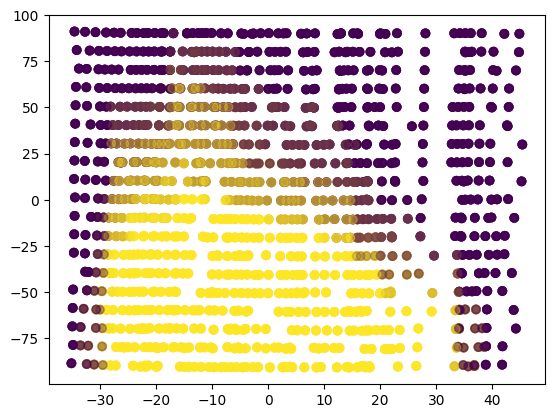

In [107]:
projector = PCA(n_components=2)
points = projector.fit_transform(X)
plt.scatter(points[:,1],points[:,0],c=y,alpha=0.2)

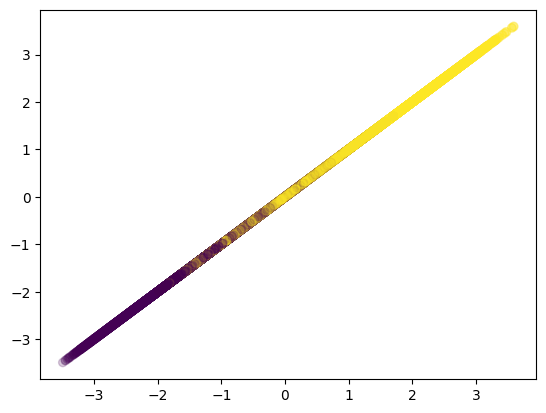

In [111]:
projector = LDA(n_components=1)
points = projector.fit_transform(X,y)
plt.scatter(points,points,c=y,alpha=0.2)

In [112]:
def experiment3(X,y,model):
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    return classification_report(y_test, y_pred),y_test,y_pred

              precision    recall  f1-score   support

           0       0.86      0.89      0.88      2607
           1       0.89      0.85      0.87      2626

    accuracy                           0.87      5233
   macro avg       0.87      0.87      0.87      5233
weighted avg       0.87      0.87      0.87      5233



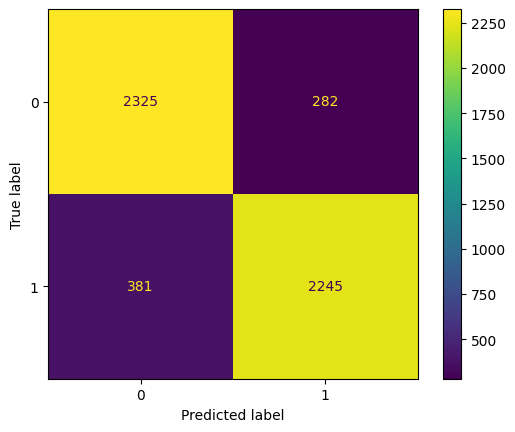

In [116]:
model = LogisticRegression()
report,y_test,y_pred = experiment3(X,y,model)
print(report)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      2653
           1       0.91      0.87      0.89      2580

    accuracy                           0.89      5233
   macro avg       0.89      0.89      0.89      5233
weighted avg       0.89      0.89      0.89      5233



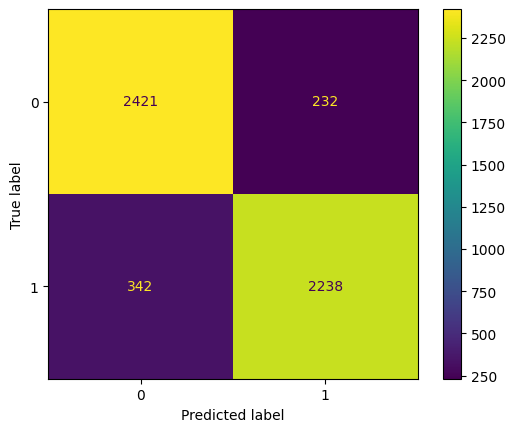

In [117]:
model = SVC()
report,y_test,y_pred = experiment3(X,y,model)
print(report)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

In [124]:
model = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8)
res = model.fit(X_train,y_train)
report = permutation_importance(model,X_test,y_test,n_repeats=30)

Unfortunately, the scikit learn's Logistic Regression doesn't come with an ANOVA analysis. Instead of ANOVA we can do [permutation importance](https://scikit-learn.org/stable/modules/permutation_importance.html). Read the documentation and examples in scikit-learn's documentation.

According to the permutation importance results, AIRFLOW appears to be the most important variable followed by DISTANCE.

In [129]:
for i in report.importances_mean.argsort()[::-1]:
    if report.importances_mean[i] - 2 * report.importances_std[i] > 0:
        print(f"{X.columns[i]:<18}"
              f"{report.importances_mean[i]:.3f}"
              f" +/- {report.importances_std[i]:.3f}")

AIRFLOW           0.219 +/- 0.007
DISTANCE          0.059 +/- 0.005
FREQUENCY         0.016 +/- 0.004
SIZE              0.007 +/- 0.002


## Q4

Use the hyperspectral image data (ROSIS sensor data over Pavia Italy) we used for Question 2 from HW1 for this question.

1. Load both the image data and the ground truth data. Reshape the image and name is as `vectors` and the ground truth data as `labels`. 
2. Remove all data points whose label is 0.
3. Write a function that construct a multi-label logistic regression model relating `vectors` to `labels`, and analyzes the accuracy using a correct statistical methodology. Analyze the accuracy results.
4. Now, run a model once over a single training and test set. Report the accuracy, precision, recall, and F1 per label basis. 
5. Repeat (3) and (4) for a multi-label SVM model.
6. Construct confusion matrices over a single run for both LR and SVM, and compare. Present your conclusions.

In [56]:
image = loadmat('../data/PaviaU.mat')['paviaU']
gt = loadmat('../data/PaviaU_gt.mat')['paviaU_gt']

vectors = image[gt!=0]
labels = gt[gt!=0]

In [76]:
def experiment4a(X,y,model,N,train=0.6):
    res = []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train)
        model = model(max_iter=5000)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        res.append(accuracy_score(y_test, y_pred))
    mean = np.mean(res)
    return {'mean': mean, 
            'interval': st.t.interval(0.05, df=N-1, loc=mean, scale=st.sem(res))}

In [75]:
experiment4a(vectors,labels,10)

/home/kaygun/local/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/kaygun/local/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

{'mean': 0.8548975298059689,
 'interval': (0.8548405264920702, 0.8549545331198676)}

              precision    recall  f1-score   support

           1       0.85      0.89      0.87      1981
           2       0.88      0.95      0.91      5629
           3       0.83      0.73      0.77       638
           4       0.93      0.91      0.92       942
           5       1.00      1.00      1.00       403
           6       0.77      0.52      0.62      1471
           7       0.79      0.62      0.69       389
           8       0.74      0.79      0.76      1096
           9       0.99      0.99      0.99       284

    accuracy                           0.86     12833
   macro avg       0.86      0.82      0.84     12833
weighted avg       0.85      0.86      0.85     12833



/home/kaygun/local/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


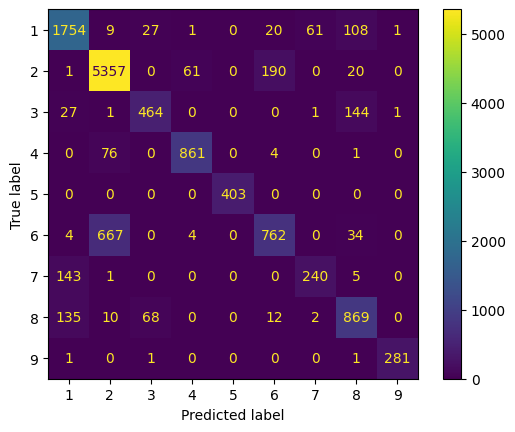

In [79]:
model = LogisticRegression(max_iter=4000)
report,y_test,y_pred = experiment4b(vectors,labels,model)
print(report)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

              precision    recall  f1-score   support

           1       0.85      0.94      0.89      1995
           2       0.90      0.99      0.94      5638
           3       0.87      0.54      0.66       639
           4       0.97      0.90      0.93       908
           5       1.00      0.99      0.99       413
           6       0.96      0.66      0.78      1498
           7       0.97      0.43      0.59       388
           8       0.77      0.94      0.85      1079
           9       1.00      1.00      1.00       275

    accuracy                           0.89     12833
   macro avg       0.92      0.82      0.85     12833
weighted avg       0.90      0.89      0.89     12833



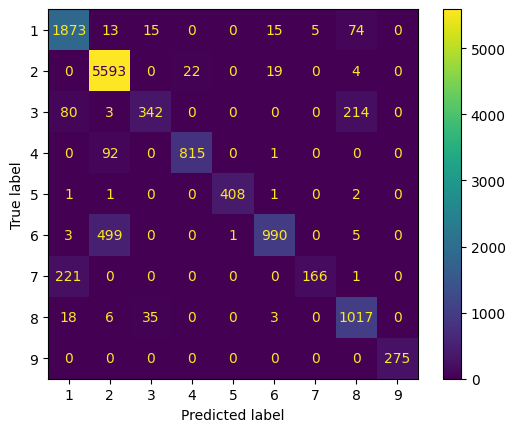

In [80]:
model = SVC()
report,y_test,y_pred = experiment4b(vectors,labels,model)
print(report)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

Overall SMV model performs better than the logistic regression model.